# Diffusion for two grains in contact


Written by: Chandan Kumar Sahu

Integrated MSc. Physics, NISER Bhubaneswar, India

Supervisors: Dr. Priyadarshi Chowdhury (SEPS, NISER) and Dr. Subhasis Basak (SPS, NISER)

In [1]:
from grain_diffusion_code_pack import *

In [2]:
# Function to calculate the diffusion coefficient using the formula given in the paper
def get_Diff(T, P, f_O2, X_Fe):
    log_D0 = -9.21 - (201000 + (P-1e5)*7e-6)/(2.303*8.314*T) + 1/6*np.log(f_O2/1e7) + 3*(X_Fe-0.1)
    return np.exp(log_D0)


# Ol6a data - Obtaining  

Diffusion coefficient: 30488.883866 microns^2/hr or 8.4691e-12 m^2/s

Calculating best fit for t_max...
Total time: 0.0119 hours or 42.9067 seconds
Root mean square error: 0.1702077126955463



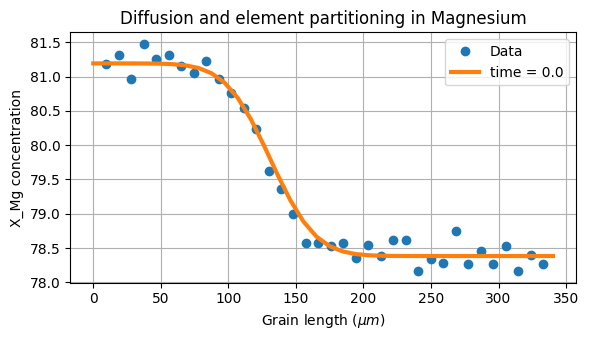

In [3]:
# Load the data
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_Ol6a.csv', delimiter="\t", skiprows=8)
Dist = DATA[7:, 0]-55           # Length of the grain in microns
X_Fo = DATA[7:, 1]              # Olivine concentration

# Constants and parameters
L_grain1 = 140                  # length of the grain 1
L_grain2 = 350-140              # length of the grain 2
dt = 1e-5                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))     # spatial step size

# Diffusion coefficient calculation
Diff = get_Diff(1083, 2e8, 1e-10, 0.1) *(3600/1e-12)
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return np.average(X_Fo[:10])

def init_X_Fo_right(X_Fo):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-10:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 1e-4, 1, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max*3600, 4), 'seconds')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, X_Fo, Dist)
plt.show()


Diffusion coefficient: 30488.883866 microns^2/hr or 8.4691e-12 m^2/s

Calculating best fit for t_max...
Total time: 0.0159 hours or 57.1579 seconds
Root mean square error: 0.4890547396160518



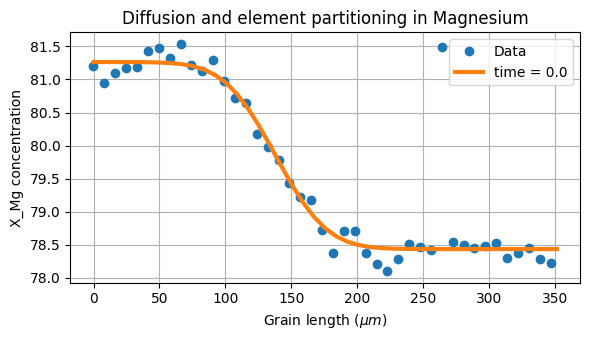

In [6]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_Ol6b.csv', delimiter="\t", skiprows=8)
Dist = DATA[7:, 0]-58           # Length of the grain in microns
X_Fo = DATA[7:, 1]              # Olivine concentration

# Constants and parameters
L_grain1 = 143                  # length of the grain 1
L_grain2 = 360-143              # length of the grain 2
dt = 1e-6                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))     # spatial step size

# Diffusion coefficient calculation
Diff = get_Diff(1083, 2e8, 1e-10, 0.1) *(3600/1e-12)
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return np.average(X_Fo[:10])

def init_X_Fo_right(X_Fe):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-10:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 1e-4, 1, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max*3600, 4), 'seconds')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, X_Fo, Dist)
plt.show()


Diffusion coefficient: 30488.883866 microns^2/hr or 8.4691e-12 m^2/s

Calculating best fit for t_max...
Total time: 0.0047 hours or 16.9494 seconds
Root mean square error: 0.31302871773555596



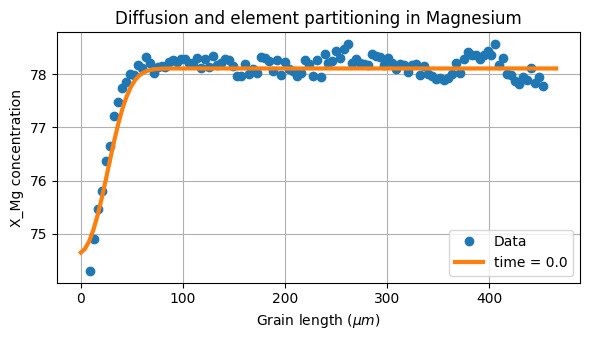

In [7]:
DATA = np.loadtxt('/home/ws1/Computational-Physics-Term-Paper-Project/Element_Partitioning_and_Diffusion/Data_files/PS3_SanPedro.csv', delimiter="\t", skiprows=9)
Dist = DATA[:, 0]-30            # Length of the grain in microns
X_Fo = DATA[:, 1]               # Olivine concentration

# Constants and parameters
L_grain1 = 30                   # length of the grain 1
L_grain2 = 470-30               # length of the grain 2
dt = 1e-6                       # time step
z_max = L_grain1 + L_grain2
dl = z_max / (len(Dist))        # spatial step size

# Diffusion coefficient calculation
Diff = get_Diff(1083, 2e8, 1e-10, 0.1) *(3600/1e-12)
print('Diffusion coefficient:', np.round(Diff, 6), 'microns^2/hr or {:.4e}'.format(Diff*1e-12/3600), 'm^2/s')
tol = 1e-6                      # tolerance for the minimization function

# Source term
def source_term(x, t):
    return 0

########################################### X_Fo ###########################################

def init_X_Fo_left(X_Fo):
    # Initial condition for at the left side of the Olivine data
    return X_Fo[0]

def init_X_Fo_right(X_Fe):
    # Initial condition for at the right side of the Olivine data
    return np.average(X_Fo[-30:-1])

def func_Fo(t_max):
    # Function to calculate the root mean square error for the Olivine data
    solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, 
                                                                    init_X_Fo_left, init_X_Fo_right, source_term, 
                                                                    diff_matrix_isolated_boundary_G2)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(np.sum(((X_Fo - solution_Fo[:, -1])**2))/len(X_Fo))
    return rmse

print('\nCalculating best fit for t_max...')
t_max = find_min_solution(func_Fo, 1e-4, 1, tol=tol)
print('Total time:', np.round(t_max, 4), 'hours or',np.round(t_max*3600, 4), 'seconds')
print('Root mean square error:', func_Fo(t_max))
print()

# Calculate the diffusion equation solution
solution_Fo, spatial_grid, time_grid = crank_nicolson_diffusion(L_grain1, L_grain2, t_max, dt, Diff, Diff, X_Fo, init_X_Fo_left, init_X_Fo_right, source_term, diff_matrix_isolated_boundary_G2)

# Plot the diffusion equation solution
plot_diff(time_grid, spatial_grid, solution_Fo, X_Fo, Dist)
plt.show()
